## 모델링

ARIMA, Prophet, XGBoost 모델을 활용해 센터원에서 코엑스까지 가는 경로 A,B,C의 소요시간을 예측

In [211]:
# !pip install pmdarima prophet xgboost
# prophet의 경우 conda install prophet 해야 제대로 깔림

In [212]:
# matplotlib 한글폰트 깨지면 다음 코드 적기
# rc('font', family='Malgun Gothic')
# plt.rcParams['axes.unicode_minus'] = False

## ARIMA

In [145]:
import pandas as pd
# Load the uploaded file
df_uploaded = pd.read_excel("경로별_소요시간_20241202.xlsx")

# Combine date and time columns to create a datetime index
df_uploaded['datetime'] = pd.to_datetime(
    df_uploaded['날짜'].astype(str) + ' ' + df_uploaded['시간'].astype(str).str.zfill(4).str[:2] + ':' + df_uploaded['시간'].astype(str).str.zfill(4).str[2:]
)


# Set the datetime column as the index
df_uploaded.set_index('datetime', inplace=True)

# Display the updated DataFrame with the formatted datetime index
df_uploaded.head()

,날짜,시간,경로유형,소요시간
datetime,,,,
2024-11-01 00:00:00,20241101,0,A,16.310933
2024-11-01 00:00:00,20241101,0,B,20.241982
2024-11-01 00:00:00,20241101,0,C,22.631307
2024-11-01 00:05:00,20241101,5,A,16.317805
2024-11-01 00:05:00,20241101,5,B,20.703033


In [146]:
# ARIMA는 univariate 모델이기 때문에 경로별로 모델링을 해야함. 
# 경로별로 데이터 나누기
route_a = df_uploaded[df_uploaded['경로유형'] == 'A']
route_b = df_uploaded[df_uploaded['경로유형'] == 'B']
route_c = df_uploaded[df_uploaded['경로유형'] == 'C']

In [147]:
# resample data
route_a_raw = route_a['소요시간']
route_a_hourly = route_a_raw.resample('1H').mean()


route_b_raw = route_b['소요시간']
route_b_hourly = route_b_raw.resample('1H').mean()


route_c_raw = route_c['소요시간']
route_c_hourly = route_c_raw.resample('1H').mean()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15264\1860382721.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  route_a_hourly = route_a_raw.resample('1H').mean()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15264\1860382721.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  route_b_hourly = route_b_raw.resample('1H').mean()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15264\1860382721.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  route_c_hourly = route_c_raw.resample('1H').mean()


In [148]:
# Raw Data와 hourly data 비교하는 함수
import matplotlib.pyplot as plt

def visualize_data(route_data, route_raw, route_hourly):
    route_type = route_data['경로유형'][0] #'A', 'B', 'C'
    # Plot raw and resampled data
    plt.rcParams['figure.figsize'] = [14, 6]

    # Raw data plot
    plt.figure(figsize=(14, 4))
    plt.plot(route_raw, label='Raw Data (5-minute intervals)', alpha=0.7)
    plt.title(f'Route {route_type} Travel Time - Raw Data (5-minute intervals)')
    plt.ylabel('Travel Time (minutes)')
    plt.xlabel('Datetime')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Resampled data plot (1-hour intervals)
    plt.figure(figsize=(14, 4))
    plt.plot(route_hourly, label='Resampled Data (1-hour intervals)', color='orange', alpha=0.8)
    plt.title(f'Route {route_type} Travel Time - Resampled Data (1-hour intervals)')
    plt.ylabel('Travel Time (minutes)')
    plt.xlabel('Datetime')
    plt.legend()
    plt.grid(True)
    plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15264\1806637507.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  route_type = route_data['경로유형'][0] #'A', 'B', 'C'


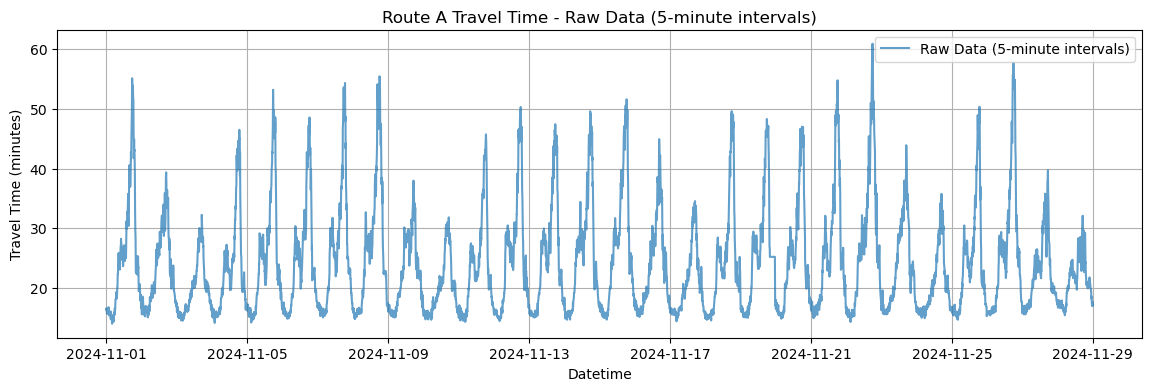

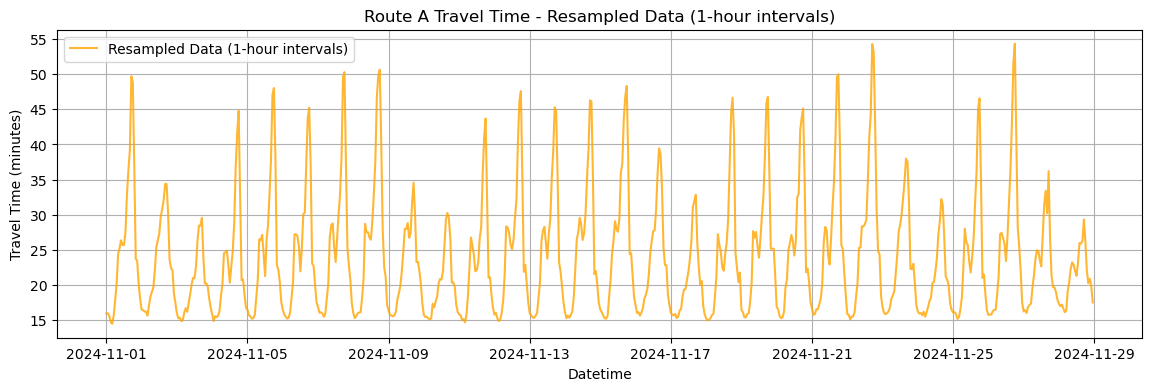

In [5]:
visualize_data(route_a, route_a_raw, route_a_hourly)

In [149]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

def seasonal_decomposition(route_hourly):
    # finds trend, season, and residuals in the data
    # Perform seasonal decomposition using moving averages (additive model)
    seasonal_decomposition = sm.tsa.seasonal_decompose(route_hourly, model='additive', period=24)

    # Plot the seasonal decomposition components
    seasonal_decomposition.plot()
    plt.show()

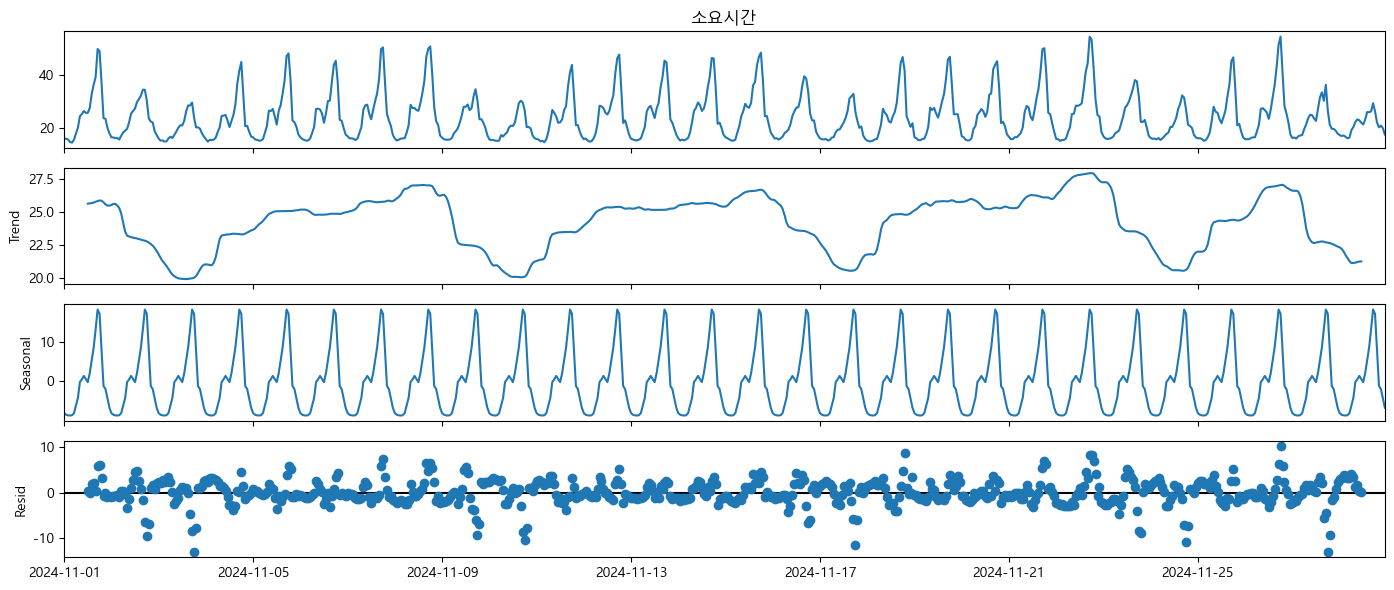

In [150]:
seasonal_decomposition(route_a_hourly)

In [151]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=24).mean()
    rolstd = timeseries.rolling(window=24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic           -3.846416
p-value                   0.002467
Lags Used                20.000000
Observations Used       651.000000
Critical Value (1%)      -3.440435
Critical Value (5%)      -2.865990
Critical Value (10%)     -2.569140
dtype: float64


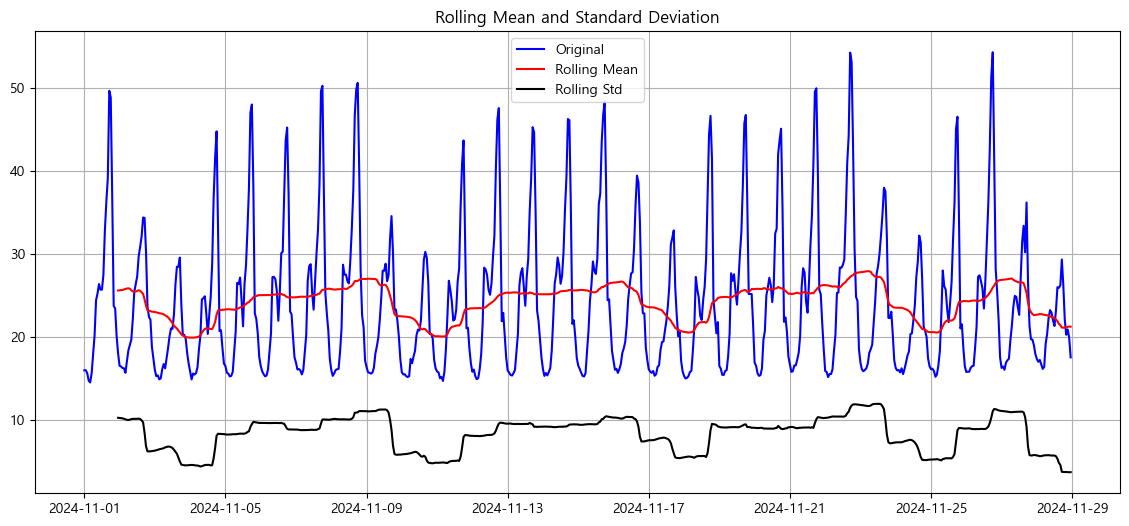

In [152]:
# run DFT on monthly
dftest(route_a_hourly)
# p-value allows us to reject a unit root: data is stationary

Test Statistic           -3.449839
p-value                   0.009373
Lags Used                20.000000
Observations Used       651.000000
Critical Value (1%)      -3.440435
Critical Value (5%)      -2.865990
Critical Value (10%)     -2.569140
dtype: float64


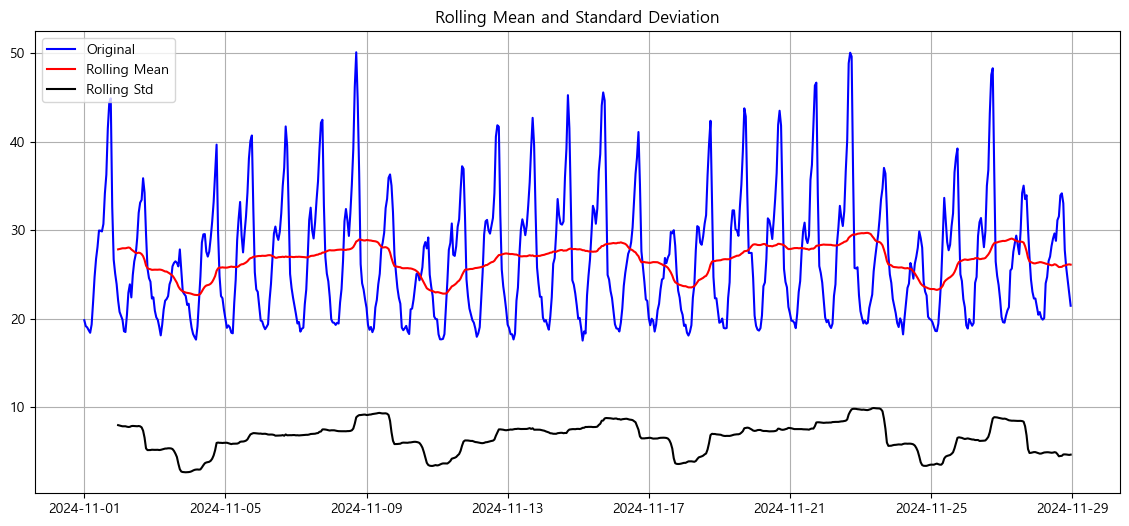

In [153]:
dftest(route_b_hourly)

Test Statistic           -3.339367
p-value                   0.013208
Lags Used                20.000000
Observations Used       651.000000
Critical Value (1%)      -3.440435
Critical Value (5%)      -2.865990
Critical Value (10%)     -2.569140
dtype: float64


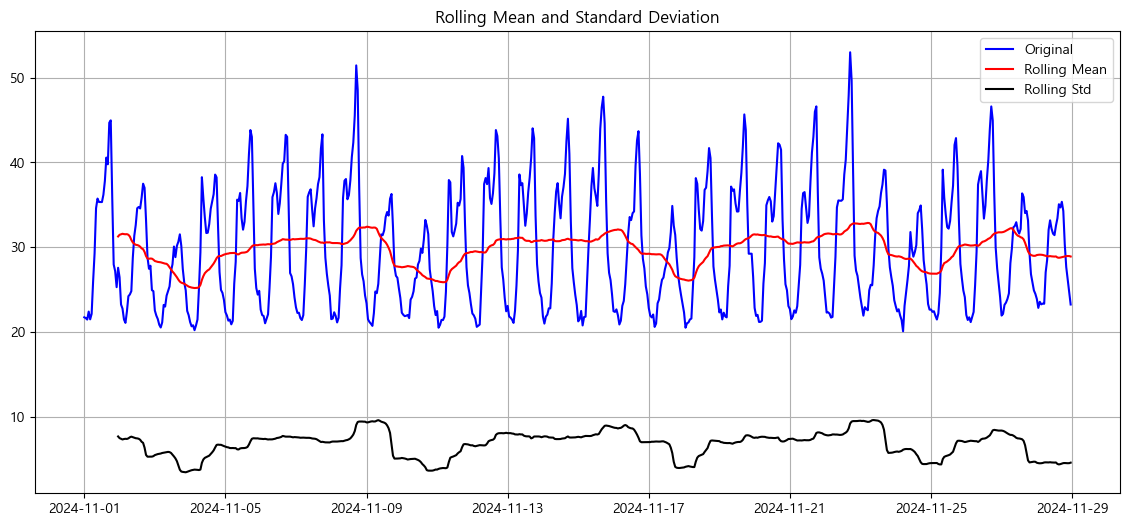

In [154]:
dftest(route_c_hourly)

In [155]:
def train_test_split(route_hourly):
    # Split the data into train and test based on the specified dates
    train_data = route_hourly['2024-11-01':'2024-11-22']  # Train data: 2024-11-01 to 2024-11-22
    test_data = route_hourly['2024-11-23':]               # Test data: 2024-11-23 onwards

    # Display the train and test data information
    print(train_data.head(), test_data.head())

    return train_data, test_data

In [156]:
train_data_a, test_data_a = train_test_split(route_a_hourly)
train_data_b, test_data_b = train_test_split(route_b_hourly)
train_data_c, test_data_c = train_test_split(route_c_hourly)


datetime
2024-11-01 00:00:00    15.971966
2024-11-01 01:00:00    15.992207
2024-11-01 02:00:00    15.623062
2024-11-01 03:00:00    14.731014
2024-11-01 04:00:00    14.507597
Freq: h, Name: 소요시간, dtype: float64 datetime
2024-11-23 00:00:00    16.891862
2024-11-23 01:00:00    16.081922
2024-11-23 02:00:00    15.860511
2024-11-23 03:00:00    16.009575
2024-11-23 04:00:00    16.219148
Freq: h, Name: 소요시간, dtype: float64
datetime
2024-11-01 00:00:00    19.853973
2024-11-01 01:00:00    19.192148
2024-11-01 02:00:00    19.035430
2024-11-01 03:00:00    18.720599
2024-11-01 04:00:00    18.434614
Freq: h, Name: 소요시간, dtype: float64 datetime
2024-11-23 00:00:00    20.883305
2024-11-23 01:00:00    20.128434
2024-11-23 02:00:00    19.496970
2024-11-23 03:00:00    19.783199
2024-11-23 04:00:00    19.451483
Freq: h, Name: 소요시간, dtype: float64
datetime
2024-11-01 00:00:00    21.721442
2024-11-01 01:00:00    21.624271
2024-11-01 02:00:00    21.451645
2024-11-01 03:00:00    22.397745
2024-11-01 04:00:00

In [157]:
from pmdarima import auto_arima

# ARIMA 최적 파라미터 찾는 함수
def fit_model(train):
    model_arima = auto_arima(train, trace=True, error_action='ignore',  
                         m=24, seasonal=True,
                         suppress_warnings=True)
    model_arima.fit(train)
    return model_arima


In [158]:
arima_a = fit_model(train_data_a)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=2.73 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=3805.717, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=2911.730, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=4939.496, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=3247.817, Time=0.07 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=2561.399, Time=1.93 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=2622.455, Time=1.02 sec
 ARIMA(0,0,1)(2,0,1)[24] intercept   : AIC=inf, Time=4.92 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=2500.298, Time=6.62 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=2762.931, Time=3.68 sec
 ARIMA(0,0,1)(2,0,2)[24] intercept   : AIC=inf, Time=7.41 sec
 ARIMA(0,0,0)(1,0,2)[24] intercept   : AIC=inf, Time=5.20 sec
 ARIMA(1,0,1)(1,0,2)[24] intercept   : AIC=inf, Time=6.55 sec
 ARIMA(0,0,2)(1,0,2)[24] intercept   : AIC=2374.9

In [27]:
arima_b = fit_model(train_data_b)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=2.99 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=3571.455, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=1.61 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=2671.537, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=5008.266, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=3015.692, Time=0.08 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=2309.187, Time=1.78 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=2377.982, Time=0.98 sec
 ARIMA(0,0,1)(2,0,1)[24] intercept   : AIC=inf, Time=4.39 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=inf, Time=6.03 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=2565.668, Time=2.52 sec
 ARIMA(0,0,1)(2,0,0)[24] intercept   : AIC=2373.103, Time=4.83 sec
 ARIMA(0,0,1)(2,0,2)[24] intercept   : AIC=inf, Time=6.90 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=2741.487, Time=1.11 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=i

In [159]:
arima_c = fit_model(train_data_c)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=2.92 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=3591.231, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=2686.675, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=5118.241, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=3029.477, Time=0.10 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=2355.882, Time=2.01 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=2418.713, Time=0.93 sec
 ARIMA(0,0,1)(2,0,1)[24] intercept   : AIC=inf, Time=6.80 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=inf, Time=9.60 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=2585.157, Time=2.86 sec
 ARIMA(0,0,1)(2,0,0)[24] intercept   : AIC=2413.039, Time=6.72 sec
 ARIMA(0,0,1)(2,0,2)[24] intercept   : AIC=inf, Time=6.52 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=2797.244, Time=1.88 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=i

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 모델 평가하는 함수
def evaluate_model(model, test, route_hourly):
    # Predictions and confidence intervals from ARIMA on the log scale
    prediction_arima, conf_int = model.predict(len(test), return_conf_int=True, alpha=0.05)

    # Combine true and predicted values into a DataFrame
    df = pd.concat([route_hourly, prediction_arima], axis=1).dropna()
    df.columns = ['true', 'prediction']

    # # Reverse the log transformation
    # df_log["true_original"] = np.exp(df_log["true"])
    # df_log["prediction_original"] = np.exp(df_log["prediction"])

    # Calculate MSE and MAE on the original scale
    mse_arima = mean_squared_error(df["true"], df["prediction"])
    mae_arima = mean_absolute_error(df["true"], df["prediction"])
    r2_score_arima = r2_score(df["true"], df["prediction"])

    print("Mean Square Error ARIMA:", mse_arima)
    print("Mean Absolute Error ARIMA:", mae_arima)
    print("R2 Score for ARIMA:", r2_score_arima)
    return df, mse_arima, mae_arima, r2_score_arima, conf_int

In [54]:
df_a, mse_a, mae_a, r2_score_a, conf_int_a = evaluate_model(arima_a, test_data_a, route_a_hourly)

Mean Square Error ARIMA: 25.897027123476114
Mean Absolute Error ARIMA: 3.182532234155923
R2 Score for ARIMA: 0.545304360849603


In [55]:
df_b, mse_b, mae_b, r2_score_b, conf_int_b = evaluate_model(arima_b, test_data_b, route_b_hourly)

Mean Square Error ARIMA: 11.93556764518451
Mean Absolute Error ARIMA: 2.265158028967821
R2 Score for ARIMA: 0.6693989033641313


In [56]:
df_c, mse_c, mae_c, r2_score_c, conf_int_c = evaluate_model(arima_c, test_data_c, route_c_hourly)

Mean Square Error ARIMA: 9.370096191812008
Mean Absolute Error ARIMA: 2.1846491386651072
R2 Score for ARIMA: 0.7432509713994973


In [57]:
# 미래 예측 시각화
def plot_forecast(route_hourly, df, conf_int):
    # plot confidence interval
    # ax = route_a_hourly.plot(label='Observed Estimated Travel Time')
    ax = route_hourly.plot(label='Observed Estimated Travel Time')
    # forecast_original = np.exp(df_log.prediction)
    df.prediction.plot(label='Forecast', ax=ax)
    # conf_int_original = np.exp(conf_int_log)

    ax.fill_between(df.index, conf_int[:,0],
                    conf_int[:,1], color='k', alpha=.25)

    # ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2024-11-23'), route_a_hourly.index[-1],
    #                  alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated Travel Time')

    plt.legend()
    plt.show()

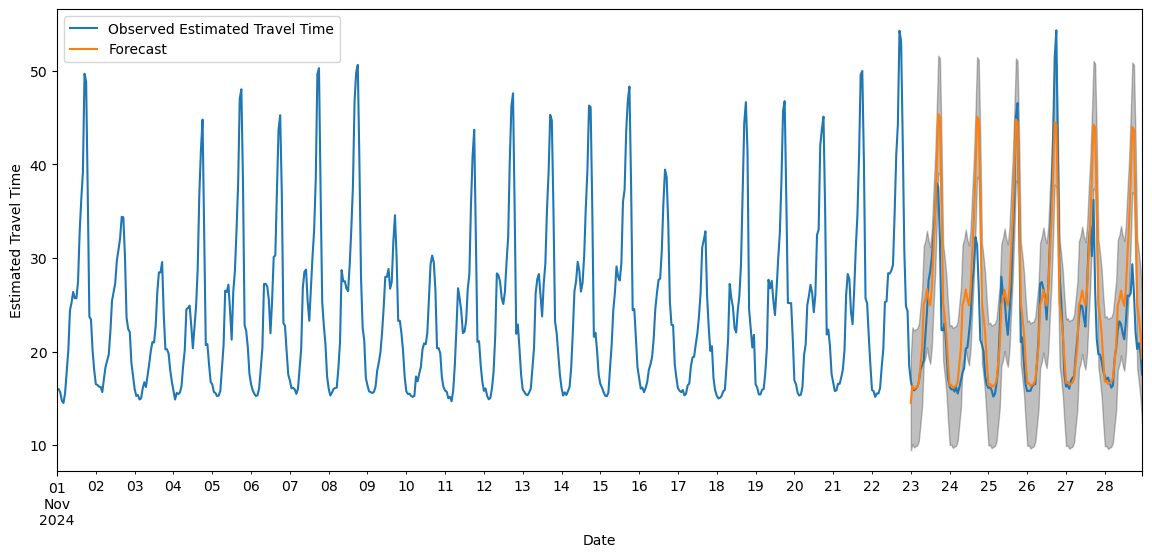

In [58]:
plot_forecast(route_a_hourly, df_a, conf_int_a)

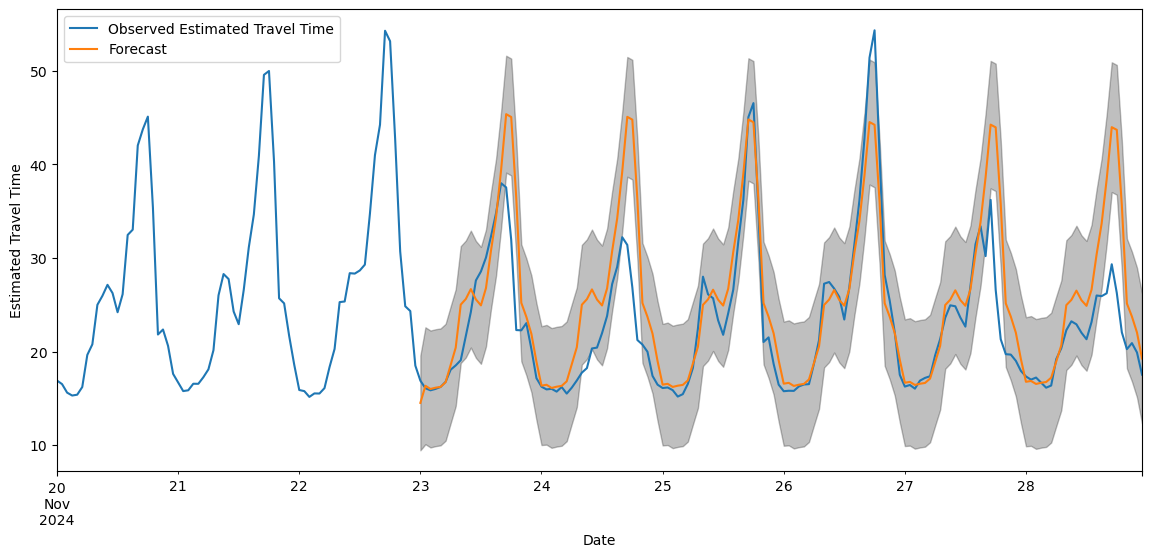

In [61]:
plot_forecast(route_a_hourly['2024-11-20':], df_a, conf_int_a)

In [161]:
# 실시간 예측 (예: 2024-12-10 오전10시 경로별로 소요시간 예측)
n_hours_ahead = 419
forecast_a = arima_a.predict(n_periods=n_hours_ahead)

# Value for 2024-12-10, 10:00 AM
predicted_value = forecast_a[-1]
print(f"2024-12-10, 10:00 AM A경로 소요시간: {predicted_value}")

2024-12-10, 10:00 AM A경로 소요시간: 25.428901001602256


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15264\2285394299.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_value = forecast_a[-1]


In [162]:
# Predict 9194 hours ahead
n_hours_ahead = 419
forecast_b = arima_b.predict(n_periods=n_hours_ahead)

# Value for 2024-12-10, 10:00 AM
predicted_value = forecast_b[-1]
print(f"2024-12-10, 10:00 AM B경로 소요시간: {predicted_value}")

2024-12-10, 10:00 AM B경로 소요시간: 29.865648720922316


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15264\1646791021.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_value = forecast_b[-1]


In [163]:
# Predict 9194 hours ahead
n_hours_ahead = 419
forecast_c = arima_c.predict(n_periods=n_hours_ahead)

# Value for 2024-12-10, 10:00 AM
predicted_value = forecast_c[-1]
print(f"2024-12-10, 10:00 AM C경로 소요시간: {predicted_value}")

2024-12-10, 10:00 AM C경로 소요시간: 33.083885076798566


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15264\3525575589.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_value = forecast_c[-1]


보면 알겠지만 ARIMA의 경우 평일, 주말 상관없이 예측값 패턴이 일정하다.. 하지만 우리 데이터는 화요일에 특히 더 변동성이 심하고 주말에는 travel time 이 전반적으로 낮다. 평일/주말 등의 특성을 고려하는 모델이 필요

## Prophet

In [180]:
from datetime import datetime
from prophet import Prophet
# 모든 과정을 함수 안에 넣어서 Route A, B, C 반복해주기

def perform_prophet(route_hourly):
    # Modify dataset to have columns ds and y
    prophet_data = route_hourly.reset_index()
    prophet_data.columns = ['ds', 'y']

    # Train and split data
    split_date = datetime(2024,11,23)
    train = prophet_data[prophet_data['ds'] < split_date]
    test = prophet_data[prophet_data['ds'] >= split_date]
    print(train.shape)
    print(test.shape)

    # Initialize and fit the model
    model_prophet = Prophet()
    model_prophet.fit(train)

    # Create a future dataframe for the next 144 hours (6 days)
    future = model_prophet.make_future_dataframe(periods=144, freq='H', include_history=True)
    future.tail()

    # populate forecast
    forecast = model_prophet.predict(future)
    forecast.tail()


    # Evaluate forecast
    df = pd.concat([test.set_index('ds'), forecast[['ds','yhat']].set_index('ds')], axis=1).dropna()

    mse_prophet = mean_squared_error(df["y"], df["yhat"])
    mae_prophet = mean_absolute_error(df["y"], df["yhat"])

    print("Mean Square Error Prophet: ", mse_prophet)
    print("Mean Absolute Error Prophet: ", mae_prophet)

    return model_prophet, forecast, train, test


In [181]:
model_prophet_a, forcast_a, train_a, test_a = perform_prophet(route_a_hourly)

16:01:08 - cmdstanpy - INFO - Chain [1] start processing
16:01:08 - cmdstanpy - INFO - Chain [1] done processing


(528, 2)
(144, 2)
Mean Square Error Prophet:  23.20189053686292
Mean Absolute Error Prophet:  3.370475452267824


d:\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [182]:
model_prophet_b, forcast_b, train_b, test_b = perform_prophet(route_b_hourly)

16:01:13 - cmdstanpy - INFO - Chain [1] start processing
16:01:14 - cmdstanpy - INFO - Chain [1] done processing


(528, 2)
(144, 2)
Mean Square Error Prophet:  10.513653116384743
Mean Absolute Error Prophet:  2.4628779183028624


d:\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [183]:
model_prophet_c, forcast_c, train_c, test_c = perform_prophet(route_c_hourly)

16:01:16 - cmdstanpy - INFO - Chain [1] start processing


(528, 2)
(144, 2)


16:01:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Square Error Prophet:  8.510202444160106
Mean Absolute Error Prophet:  2.178802855484092


d:\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [184]:
# 11월23일부터 28일까지 테스트데이터 동안의 기간을 예측 (6 days)
future = model_prophet_a.make_future_dataframe(periods=144, freq='H', include_history=True)
future.tail()

d:\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


,ds
667,2024-11-28 19:00:00
668,2024-11-28 20:00:00
669,2024-11-28 21:00:00
670,2024-11-28 22:00:00
671,2024-11-28 23:00:00


In [185]:
# populate forecast
forecast = model_prophet_a.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
667,2024-11-28 19:00:00,25.703891,32.530943,40.072690,25.690040,25.716879,10.445235,10.445235,10.445235,9.190671,9.190671,9.190671,1.254564,1.254564,1.254564,0.0,0.0,0.0,36.149127
668,2024-11-28 20:00:00,25.707634,25.303296,32.697313,25.693676,25.720739,3.431328,3.431328,3.431328,2.100515,2.100515,2.100515,1.330814,1.330814,1.330814,0.0,0.0,0.0,29.138962
669,2024-11-28 21:00:00,25.711376,20.351891,27.883934,25.697209,25.724583,-1.815102,-1.815102,-1.815102,-3.226237,-3.226237,-3.226237,1.411136,1.411136,1.411136,0.0,0.0,0.0,23.896274
670,2024-11-28 22:00:00,25.715118,17.472553,25.212699,25.700781,25.728426,-4.348581,-4.348581,-4.348581,-5.843581,-5.843581,-5.843581,1.495000,1.495000,1.495000,0.0,0.0,0.0,21.366537
671,2024-11-28 23:00:00,25.718860,17.223202,24.550507,25.704415,25.732346,-5.069037,-5.069037,-5.069037,-6.650838,-6.650838,-6.650838,1.581801,1.581801,1.581801,0.0,0.0,0.0,20.649823


In [186]:
# Evaluate forecast
df = pd.concat([test_a.set_index('ds'), forecast[['ds','yhat']].set_index('ds')], axis=1).dropna()

In [188]:
forecast_filtered = forecast.set_index('ds').loc[test_a['ds']]
forecast_filtered.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2024-11-23 00:00:00,25.183745,16.305429,23.888279,25.183745,25.183745,-4.979018,-4.979018,-4.979018,-7.140889,-7.140889,-7.140889,2.161870,2.161870,2.161870,0.0,0.0,0.0,20.204727
2024-11-23 01:00:00,25.187487,15.580239,22.716669,25.187487,25.187487,-6.038419,-6.038419,-6.038419,-8.069295,-8.069295,-8.069295,2.030876,2.030876,2.030876,0.0,0.0,0.0,19.149068
2024-11-23 02:00:00,25.191229,14.099307,21.944223,25.191229,25.191229,-7.234943,-7.234943,-7.234943,-9.120198,-9.120198,-9.120198,1.885255,1.885255,1.885255,0.0,0.0,0.0,17.956286
2024-11-23 03:00:00,25.194971,13.507051,21.171974,25.194971,25.194971,-7.842572,-7.842572,-7.842572,-9.568024,-9.568024,-9.568024,1.725452,1.725452,1.725452,0.0,0.0,0.0,17.352399
2024-11-23 04:00:00,25.198713,13.828038,21.391804,25.198703,25.198721,-7.511034,-7.511034,-7.511034,-9.063071,-9.063071,-9.063071,1.552037,1.552037,1.552037,0.0,0.0,0.0,17.687680


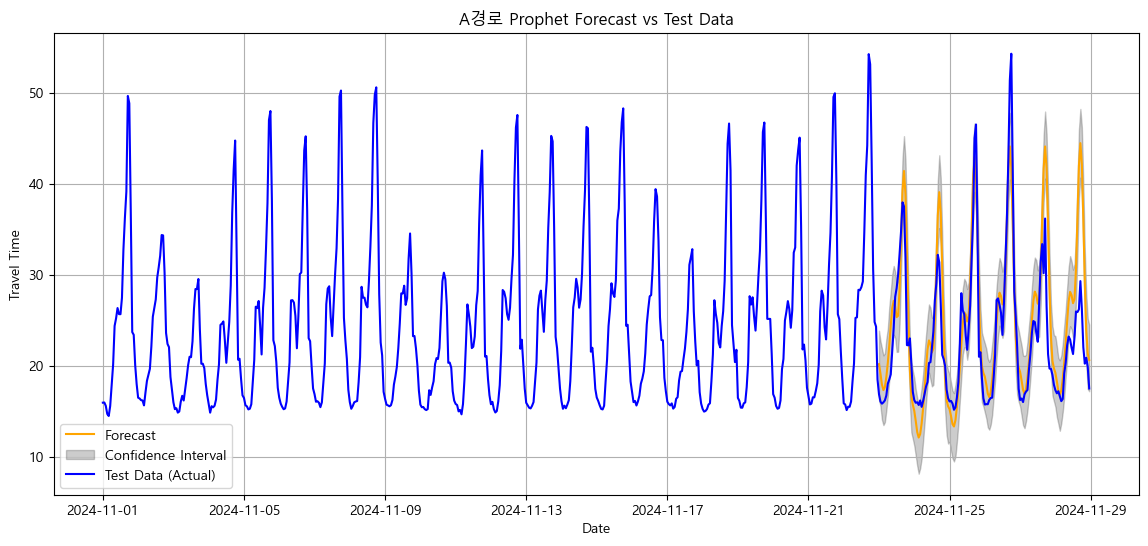

In [190]:
prophet_data = route_a_hourly.reset_index()
prophet_data.columns = ['ds', 'y']
# Filter the forecast to match the test data (from 11-23 onward)
forecast_filtered = forecast.set_index('ds').loc[test_a['ds']]

# Align test data with forecasted values
forecast_test = forecast_filtered['yhat']


# Plot the forecast and test data
plt.figure(figsize=(14, 6))

# Prophet forecast
plt.plot(forecast_filtered.index, forecast_filtered['yhat'], label='Forecast', color='orange')

# # Confidence intervals
plt.fill_between(forecast_filtered.index,
                 forecast_filtered['yhat_lower'], 
                 forecast_filtered['yhat_upper'],
                 color='k', alpha=0.2, label='Confidence Interval')

# Test data (actual values)
plt.plot(prophet_data['ds'], prophet_data['y'], label='Test Data (Actual)', color='blue')

# # Add labels, legend, and title
plt.title('A경로 Prophet Forecast vs Test Data')
plt.xlabel('Date')
plt.ylabel('Travel Time')
plt.legend()
plt.grid()
plt.show()

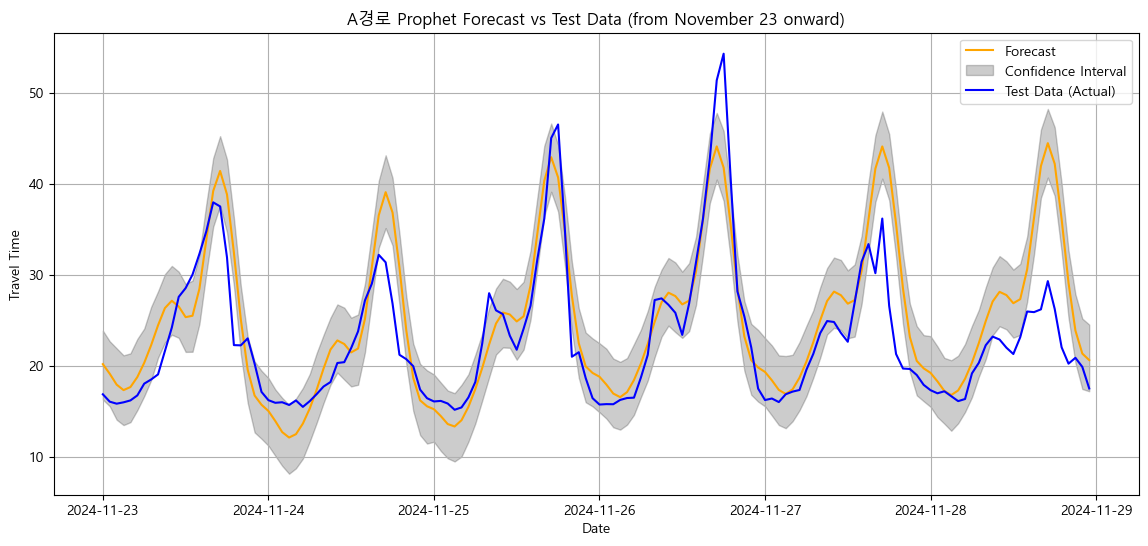

In [191]:
# Filter the forecast to match the test data (from 11-23 onward)
forecast_filtered = forecast.set_index('ds').loc[test_a['ds']]

# Align test data with forecasted values
forecast_test = forecast_filtered['yhat']


# Plot the forecast and test data
plt.figure(figsize=(14, 6))

# Prophet forecast
plt.plot(forecast_filtered.index, forecast_filtered['yhat'], label='Forecast', color='orange')

# # Confidence intervals
plt.fill_between(forecast_filtered.index,
                 forecast_filtered['yhat_lower'], 
                 forecast_filtered['yhat_upper'],
                 color='k', alpha=0.2, label='Confidence Interval')

# Test data (actual values)
plt.plot(test_a['ds'], test_a['y'], label='Test Data (Actual)', color='blue')

# # Add labels, legend, and title
plt.title('A경로 Prophet Forecast vs Test Data (from November 23 onward)')
plt.xlabel('Date')
plt.ylabel('Travel Time')
plt.legend()
plt.grid()
plt.show()


In [196]:
# 실시간 예측: 12월 10일 오전 10시 소요시간을 예측
def predict_real_time(model):
    future = model.make_future_dataframe(periods=420, freq='H', include_history=True)
    # Predict future values
    forecast = model.predict(future)

    # Filter the prediction for 2024-12-10 10:00 AM
    target_time = '2024-12-10 10:00:00'
    predicted_value = forecast[forecast['ds'] == target_time]['yhat'].values[0]

    print(f"Predicted value for 2024-12-10, 10:00 AM: {predicted_value}")
    return None

In [200]:
predict_real_time(model_prophet_a)
predict_real_time(model_prophet_b)
predict_real_time(model_prophet_c)

d:\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Predicted value for 2024-12-10, 10:00 AM: 29.313458546438017
Predicted value for 2024-12-10, 10:00 AM: 33.72999607446206


d:\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
d:\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Predicted value for 2024-12-10, 10:00 AM: 37.434553831623205


## XG Boost

In [201]:
# Feature Engineering
df_uploaded['Hour'] = df_uploaded.index.hour
df_uploaded['DayOfWeek'] = df_uploaded.index.dayofweek
df_uploaded['IsWeekend'] = df_uploaded['DayOfWeek'].isin([5, 6]).astype(int)

In [202]:
# Add Rush Hour Feature
def is_rush_hour(hour):
    return 1 if (7 <= hour <= 9 or 17 <= hour <= 19) else 0

df_uploaded['IsRushHour'] = df_uploaded['Hour'].apply(is_rush_hour)

In [203]:
df_uploaded.tail()

,날짜,시간,경로유형,소요시간,Hour,DayOfWeek,IsWeekend,IsRushHour
datetime,,,,,,,,
2024-11-28 23:50:00,20241128,2350,B,22.142643,23,3,0,0
2024-11-28 23:50:00,20241128,2350,C,22.690249,23,3,0,0
2024-11-28 23:55:00,20241128,2355,A,17.060813,23,3,0,0
2024-11-28 23:55:00,20241128,2355,B,21.395654,23,3,0,0
2024-11-28 23:55:00,20241128,2355,C,23.267316,23,3,0,0


In [204]:
# 경로 A,B,C 를 인코딩
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
route_encoded = encoder.fit_transform(df_uploaded[['경로유형']])
route_encoded_df = pd.DataFrame(route_encoded, columns=encoder.get_feature_names_out(['경로유형']))
df_uploaded = pd.concat([df_uploaded.reset_index(drop=True), route_encoded_df.reset_index(drop=True)], axis=1)


In [206]:
# Combine '날짜' and '시간' columns to create a datetime index
df_uploaded['datetime'] = pd.to_datetime(df_uploaded['날짜'].astype(str) + ' ' + df_uploaded['시간'].astype(str).str.zfill(4), format='%Y%m%d %H%M')

# Set 'datetime' as the index
df_uploaded.set_index('datetime', inplace=True)

df_uploaded.head()

,날짜,시간,경로유형,소요시간,Hour,DayOfWeek,IsWeekend,IsRushHour,경로유형_A,경로유형_B,경로유형_C
datetime,,,,,,,,,,,
2024-11-01 00:00:00,20241101,0,A,16.310933,0,4,0,0,1.0,0.0,0.0
2024-11-01 00:00:00,20241101,0,B,20.241982,0,4,0,0,0.0,1.0,0.0
2024-11-01 00:00:00,20241101,0,C,22.631307,0,4,0,0,0.0,0.0,1.0
2024-11-01 00:05:00,20241101,5,A,16.317805,0,4,0,0,1.0,0.0,0.0
2024-11-01 00:05:00,20241101,5,B,20.703033,0,4,0,0,0.0,1.0,0.0


In [207]:
# Split to train and test based on date
train = df_uploaded.loc[df_uploaded.index < '11-23-2024']
test = df_uploaded.loc[df_uploaded.index >= '11-23-2024']

In [208]:
train.head(2)

,날짜,시간,경로유형,소요시간,Hour,DayOfWeek,IsWeekend,IsRushHour,경로유형_A,경로유형_B,경로유형_C
datetime,,,,,,,,,,,
2024-11-01,20241101,0,A,16.310933,0,4,0,0,1.0,0.0,0.0
2024-11-01,20241101,0,B,20.241982,0,4,0,0,0.0,1.0,0.0


In [213]:
df_uploaded.columns

Index(['날짜', '시간', '경로유형', '소요시간', 'Hour', 'DayOfWeek', 'IsWeekend',
       'IsRushHour', '경로유형_A', '경로유형_B', '경로유형_C'],
      dtype='object')

In [215]:
FEATURES = ['Hour', 'DayOfWeek', 'IsWeekend', 'IsRushHour', '경로유형_A', '경로유형_B', '경로유형_C']
TARGET = '소요시간'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [217]:
X_train.head(2)

,Hour,DayOfWeek,IsWeekend,IsRushHour,경로유형_A,경로유형_B,경로유형_C
datetime,,,,,,,
2024-11-01,0,4,0,0,1.0,0.0,0.0
2024-11-01,0,4,0,0,0.0,1.0,0.0


In [218]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 500, 1000],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Set up the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', cv=3, verbose=2)

# Perform the search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END 

In [219]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

best_model = xgb.XGBRegressor(
    colsample_bytree=1.0,
    learning_rate=0.01,
    max_depth=5,
    n_estimators=1000,
    subsample=0.8,
    objective='reg:squarederror',  # Use appropriate objective
    random_state=42,
    early_stopping_rounds=50
)

# Train the model
best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}, MSE: {mse:.3f}, R^2: {r2:.3f}")

[0]	validation_0-rmse:7.08756


[100]	validation_0-rmse:3.66528
[200]	validation_0-rmse:3.13742
[300]	validation_0-rmse:3.13929
[307]	validation_0-rmse:3.14152
MAE: 1.972, MSE: 9.747, R^2: 0.807


In [220]:
importance = best_model.feature_importances_
for col, imp in zip(X_train.columns, importance):
    print(f"{col}: {imp:.2f}")

Hour: 0.48
DayOfWeek: 0.08
IsWeekend: 0.00
IsRushHour: 0.04
경로유형_A: 0.16
경로유형_B: 0.04
경로유형_C: 0.18


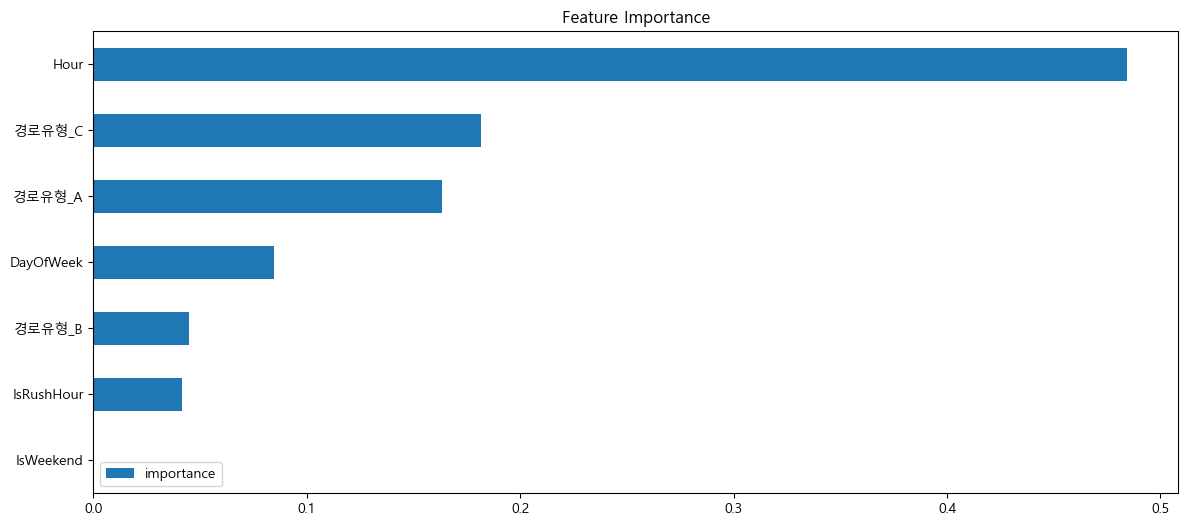

In [221]:
fi = pd.DataFrame(data=best_model.feature_importances_,
             index=best_model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_31448\3859846226.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = y_pred


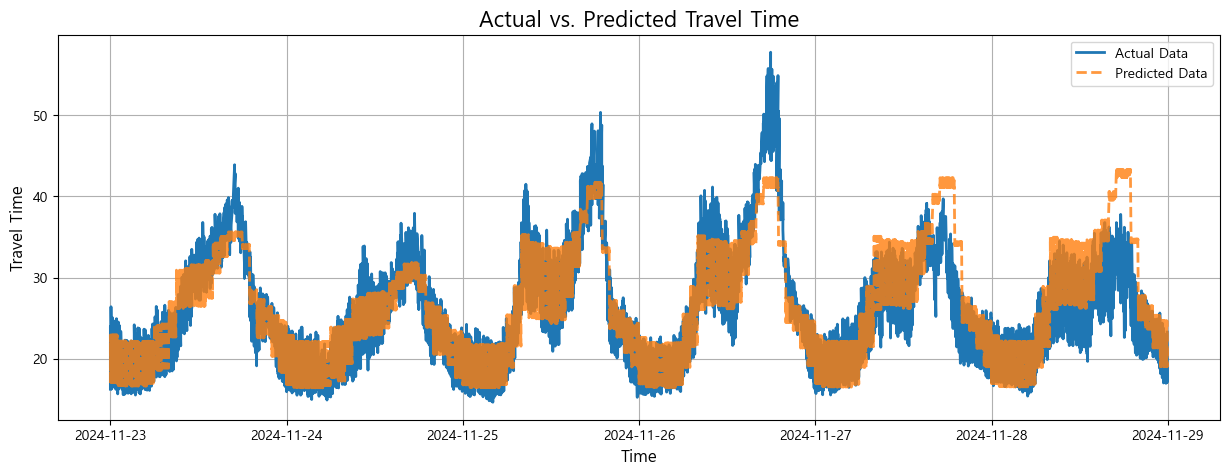

In [125]:
# Add predictions to the test set for visualization
test['prediction'] = y_pred

# Plot actual vs. predicted values
plt.figure(figsize=(15, 5))
plt.plot(test.index, y_test, label='Actual Data', linewidth=2)
plt.plot(test.index, test['prediction'], label='Predicted Data', linestyle='--', linewidth=2, alpha=0.8)

# Add legend and title
plt.legend(['Actual Data', 'Predicted Data'], loc='upper right')
plt.title('Actual vs. Predicted Travel Time', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Travel Time', fontsize=12)
plt.grid(True)
plt.show()

In [222]:
# 12월 10일 오전 10시 소요시간 을 예측
# 모델에 월, 일은 변수에 들어가 있지 않아 화요일 10시로 넣어서 경로별로 예측
target_time = pd.DataFrame({
    'Hour': [10],         # 10시
    'DayOfWeek': [1],     # 화요일 (0=월요일, 1=화요일, ...)
    'IsWeekend': [0],     # 주말 아님
    'IsRushHour': [1],    # 혼잡 시간
    '경로유형_A': [1],       # 경로 A
    '경로유형_B': [0],       # 경로 B
    '경로유형_C': [0]        # 경로 C
})

# B 경로 데이터
target_time_B = target_time.copy()
target_time_B['경로유형_A'] = 0
target_time_B['경로유형_B'] = 1
target_time_B['경로유형_C'] = 0

# C 경로 데이터
target_time_C = target_time.copy()
target_time_C['경로유형_A'] = 0
target_time_C['경로유형_B'] = 0
target_time_C['경로유형_C'] = 1

In [223]:
# A 경로 예측
predicted_value_A = best_model.predict(target_time)[0]

# B 경로 예측
predicted_value_B = best_model.predict(target_time_B)[0]

# C 경로 예측
predicted_value_C = best_model.predict(target_time_C)[0]

print(f"Predicted value for Route A at 2024-12-10 10:00 AM: {predicted_value_A}")
print(f"Predicted value for Route B at 2024-12-10 10:00 AM: {predicted_value_B}")
print(f"Predicted value for Route C at 2024-12-10 10:00 AM: {predicted_value_C}")

Predicted value for Route A at 2024-12-10 10:00 AM: 26.63749885559082
Predicted value for Route B at 2024-12-10 10:00 AM: 30.1190185546875
Predicted value for Route C at 2024-12-10 10:00 AM: 34.69507598876953
